In [1]:
import sys
sys.path.append("..")
import utils.interp_generators as igs
import utils.adv_ex_utils as aus
from utils.lenet import LeNet
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# makes default tensor a CUDA tensor so GPU can be used
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

In [2]:
net = LeNet(activation=torch.nn.functional.relu)
net_proxy = LeNet(activation=torch.nn.functional.softplus)

training_round = 2
net_name = f'../trained_models/training_round_{training_round}/ep{0}_wd{0}_jr{0}_{training_round}'

net.load_state_dict(torch.load(net_name))
net_proxy.load_state_dict(torch.load(net_name))

# put each model in evaluation mode. i.e. turn off dropout layers, etc.
net.eval()
net_proxy.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [3]:
data_preprocess = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(), 
                torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST(root='../data', train=True, transform=data_preprocess), 
                batch_size=1, shuffle=True)

### Compare smoothgrad to simple gradient

net(sample) = 3


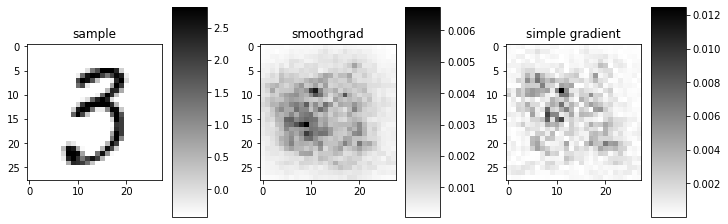

In [10]:
sample,label = next(iter(train_loader))
sample,label = sample.to(device),label.to(device)

# used = False needed if sample has not yet been converted to 
# a torch.Variable and made to require gradient
s1 = igs.smoothgrad(net, sample, label, j=15, scale=1., used=False)
s2 = igs.simple_gradients(net, sample, label, used=False)

fig = plt.figure(figsize=(10,3), constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

print(f'net(sample) = {torch.argmax(net(sample))}')

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample')
plt.imshow(sample.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('smoothgrad')
plt.imshow(s1.cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax3 = fig.add_subplot(spec[0,2])
ax3.title.set_text('simple gradient')
plt.imshow(s2.squeeze().cpu().detach().numpy(), cmap='binary')
plt.colorbar()

plt.show()

### Make sure that parallelized version of simple gradients is working correctly

torch.Size([2, 28, 28])
net(sample1, sample2) = tensor([9, 8])


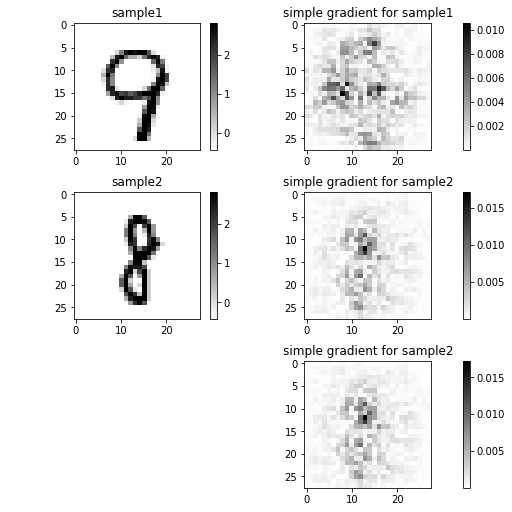

In [5]:
sample1,label1 = next(iter(train_loader))
sample2,label2 = next(iter(train_loader))
samples,labels = torch.cat([sample1,sample2],dim=0),torch.cat([label1,label2],dim=0)
samples,labels = samples.to(device),labels.to(device)

# used = False needed if sample has not yet been converted to 
# a torch.Variable and made to require gradient
s = igs.simple_gradients(net, samples, labels, used=False)
s1 = igs.simple_gradient(net, samples[1].unsqueeze(0), labels[1].unsqueeze(0), used=False)

print(s.shape)

fig = plt.figure(figsize=(7,7), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

print(f'net(sample1, sample2) = {torch.argmax(net(samples), dim=1)}')

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample1')
plt.imshow(sample1.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('simple gradient for sample1')
plt.imshow(s[0].cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax3 = fig.add_subplot(spec[1,0])
ax3.title.set_text('sample2')
plt.imshow(sample2.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax4 = fig.add_subplot(spec[1,1])
ax4.title.set_text('simple gradient for sample2')
plt.imshow(s[1].cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax5 = fig.add_subplot(spec[2,1])
ax5.title.set_text('simple gradient for sample2')
plt.imshow(s1.cpu().detach().numpy(), cmap='binary')
plt.colorbar()

plt.show()

### Inspect effect of randomly perturbing a sample

max value: 2.821486711502075, min value: -0.4242129623889923
max value: 2.987565755844116, min value: -0.6951578855514526
net(sample1) = 4, net(sample2) = 4


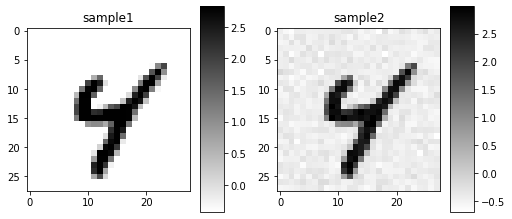

In [35]:
sample1,label1 = next(iter(train_loader))
sample1,label1 = sample1.to(device),label1.to(device)
sample2 = aus.perturb_randomly(sample1, scale=.1)
print(f'max value: {sample1.max().item()}, min value: {sample1.min().item()}')
print(f'max value: {sample2.max().item()}, min value: {sample2.min().item()}')
print(f'net(sample1) = {torch.argmax(net(sample1))}, net(sample2) = {torch.argmax(net(sample2))}')

fig = plt.figure(figsize=(7,3), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample1')
plt.imshow(sample1.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('sample2')
plt.imshow(sample2.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

plt.show()